In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
palette_hc = ['#ffffff', '#ddaa33', '#bb5566', '#004488', '#000000']

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

from tqdm.auto import tqdm

import time
import os
from collections import OrderedDict
import json
import pickle

import gc

import sys
sys.path.append("../")

from src.helpers import calculate_RMSE_balanced, calculate_RMSE, Timer, autoscaling, \
                        calculate_composite_RMSE_V_CaT, update_array_from_kwargs, get_value_by_key

from src.postprocessing import collect_results, create_C_S

idx = pd.IndexSlice

# From cluster

In [4]:
cluster_name = "pikunov.av@calc.cod.phystech.edu"
folder_name_src = "/home/common/pikunov.av/pypoptim/results/maleckar/voigt"
folder_name_dst = "../results/maleckar/voigt"

folder_name_dst = os.path.abspath(folder_name_dst)

case_list = "G1/C1/210122_051129", "G2/C2/210122_082053", "G3/C1/210121_212326", "G4/C8/210122_001806"
#case_list = "G1/C1/210122_221831", "G2/C2/210123_122249", "G3/C1/210122_142150", "G4/C8/210123_031303"

item_list = ['dump_last.npy',
             #'dump.bin',
             'phenotype/*.csv',
             'config_backup.pickle']

text = ""

for case in case_list:
    
    folder_name = os.path.join(folder_name_dst, case)
    os.makedirs(folder_name, exist_ok=True)
    
    for item in item_list:
        src = os.path.join(folder_name_src, case, item)
        head, _ = os.path.split(item)
        if head:
            dst = os.path.join(folder_name_dst, case, head)
            os.makedirs(dst, exist_ok=True)
        else:
            dst = os.path.join(folder_name_dst, case)
        request = f"scp -r {cluster_name}:{src} {dst}\n"
        text += request
        
filename_script = "../misc/from_cluster.sh"
with open(filename_script, 'w') as f:
    f.write(text)

In [5]:
%%bash

bash ../misc/from_cluster.sh

# Data loading

In [6]:
def collect_results(case, dirname_results, load_dump=False):

    idx = pd.IndexSlice

    group, cell, suffix = case.split('/')
    group, cell = int(group[-1]), int(cell[-1])

    config_path = os.path.join(dirname_results, case)
    with open(os.path.join(config_path, "config_backup.pickle"), 'rb') as f:
        config = pickle.load(f)

    genes = config['runtime']['genes_dict']
    n_genes = sum(map(len, genes.values()))

    n_organisms = config['runtime']['n_organisms']

    dump_filename = os.path.join(config_path, 'dump.bin')
    dump_last_filename = os.path.join(config_path, 'dump_last.npy')

    if os.path.isfile(dump_last_filename):
        dump_last = np.load(dump_last_filename)
        dump_last = dump_last.reshape(-1, n_genes + 1)
    else:
        dump_last = None

    if load_dump and os.path.isfile(dump_filename):
        dump = np.fromfile(dump_filename, dtype=np.half)
        dump = dump.reshape(-1, n_genes + 1)
        n_epochs = len(dump) // n_organisms
    else:
        dump = None
        n_epochs = 1

    columns_tuples = [('common', 'fitness')] + [(item[0], key) for item in genes.items() for key in item[1]]
    m_index_columns = pd.MultiIndex.from_tuples(columns_tuples)

    index_tuples = [(epoch, org) for epoch in range(n_epochs) for org in range(n_organisms)]
    m_index_index = pd.MultiIndex.from_tuples(index_tuples)

    if dump is not None:
        dump = pd.DataFrame(np.roll(dump, axis=1, shift=1),
                            index=m_index_index,
                            columns=m_index_columns)
    if dump_last is None:
        dump_last = dump.loc[idx[n_epochs - 1, :]]
        np.save(dump_last_filename, np.roll(dump_last.values, axis=1, shift=-1))
    else:
        dump_last = pd.DataFrame(np.roll(dump_last, axis=1, shift=1),
                                 columns=m_index_columns)


    phenotype_model_last = {}

    for exp_cond_name in tqdm(config['experimental_conditions'], desc='phenotype'):

        if exp_cond_name == 'common':
            continue

        filename = os.path.join(config_path, "phenotype", f"phenotype_{exp_cond_name}.csv")
        if os.path.isfile(filename):
            try:
                phenotype_model_last[exp_cond_name] = pd.read_csv(filename)
            except pd.errors.EmptyDataError as e:
                print(f'{filename} is empty')
                continue

    output_dict = dict(trio = (group, cell, suffix),
                       genes = genes,
                       dump_last = dump_last,
                       dump = dump,
                       phenotype_model_last = phenotype_model_last,
                       config = config)

    return output_dict

In [21]:
case_list = 'G3/C1/201224_215531', 'G3/C1/201224_210103', 'G3/C1/201223_220723', 
#case_list = 'G4/C8/201223_232912',
#case_list = 'G2/C2/201224_125711',
#case_list = 'G1/C1/201225_092709',

case_list = 'G3/C1/201223_220723', 
case_list = 'G3/C1/210113_133246',
case_list = 'G3/C1/210114_012849',

case_list = 'G3/C1/210114_153411',
#case_list = 'G3/C1/210114_154059',
#case_list = 'G3/C1/210114_154032',

#case_list = 'G3/C1/210114_153411', 'G3/C1/210114_154059', 'G3/C1/210114_154032'

# ical_ghk
# case_list = "G1/C1/210115_115857", # 3D ok
# case_list = "G2/C2/210115_183711", # 3D ok
case_list = 'G3/C1/210114_153411', 'G3/C1/210115_113955',
case_list = "G4/C8/210116_070854",

# case_list = "G1/C1/210115_115857", "G2/C2/210115_183711", 'G3/C1/210114_153411', "G4/C8/210116_070854"

# ical_ghk_tor
# case_list = "G1/C1/210118_200016",
# case_list = "G2/C2/210119_054105",
# case_list = "G3/C1/210118_195415",
# case_list = "G4/C8/210120_003000",

# case_list = "G1/C1/210118_200016", "G2/C2/210119_054105", "G3/C1/210118_195415", "G4/C8/210120_003000"

#ical_ghk + ical_gh_tor
case_list = ["G1/C1/210118_200016", "G2/C2/210119_054105", "G3/C1/210118_195415", "G4/C8/210120_003000",
             "G1/C1/210115_115857", "G2/C2/210115_183711", 'G3/C1/210114_153411', 'G3/C1/210115_113955', "G4/C8/210116_070854",
             ]

case_list = "G3/C1/210121_202018", "G3/C1/210121_202452"

In [7]:
# rel
case_list = "G1/C1/210122_051129", "G2/C2/210122_082053", "G3/C1/210121_212326", "G4/C8/210122_001806"
case_list += "G1/C1/210122_221831", "G2/C2/210123_122249", "G3/C1/210122_142150", "G4/C8/210123_031303"

In [8]:
output_list = []

for case in tqdm(case_list):
    
    output_dict = collect_results(case, "../results/maleckar/voigt", load_dump=True)
    #del output_dict['dump']
    gc.collect()
    output_list.append(output_dict)
    
    dirname_report = os.path.join("../images/maleckar/reports/", case)
    os.makedirs(dirname_report, exist_ok=True)

  0%|          | 0/8 [00:00<?, ?it/s]

phenotype:   0%|          | 0/5 [00:00<?, ?it/s]

phenotype:   0%|          | 0/6 [00:00<?, ?it/s]

phenotype:   0%|          | 0/5 [00:00<?, ?it/s]

phenotype:   0%|          | 0/5 [00:00<?, ?it/s]

phenotype:   0%|          | 0/5 [00:00<?, ?it/s]

phenotype:   0%|          | 0/6 [00:00<?, ?it/s]

phenotype:   0%|          | 0/5 [00:00<?, ?it/s]

phenotype:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# for case in case_list:
#     dirname = os.path.join("../results/maleckar/voigt", case)
#     filename = os.path.join(dirname, "dump_last.npy")
#     if os.path.isfile(filename):
#         print(filename)
#         os.remove(filename)

In [10]:
columns_tuples = []

for output in output_list:
    tag, genes = output['trio'], output['genes']
    for exp_cond in genes:
        for gene in genes[exp_cond]:
            t = (exp_cond, gene)
            if t not in columns_tuples:
                columns_tuples.append(t)
                
columns_tuples = [('common', 'fitness')] + columns_tuples
                
m_index = pd.MultiIndex.from_tuples(columns_tuples)

index_tuples = [x['trio'] for x in output_list]
m_index_index = pd.MultiIndex.from_tuples(index_tuples)

df_sol = pd.DataFrame([[None for item in columns_tuples]] * len(output_list),
                      columns=m_index, index=m_index_index)

for i, output in enumerate(output_list):
    trio, genes, values = output['trio'], output['genes'], output['dump_last'].iloc[0]
    columns_i = [(item[0], key) for item in genes.items() for key in item[1]]
    columns_i = [('common', 'fitness')] + columns_i
    for j, c in enumerate(columns_i):
        df_sol.loc[trio, c] = values[j]
        
df_sol.index.names = ['Group', 'Cell', 'Case']
df_sol = df_sol.T.sort_index(axis='columns')

/home/andrey/WORK/HPL/Code/conda_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [11]:
df_sol

Group                        1                           2                \
Cell                         1                           2                 
Case             210122_051129 210122_221831 210122_082053 210123_122249   
common fitness       -5.298441     -5.975612     -7.121337     -7.045137   
       P_Na           0.802082      0.800782      0.801676      0.804289   
       g_Ca_L         0.090930      0.081260      0.201085      0.050906   
       pca_tor        1.123805          None      0.406364          None   
       g_t            0.197093      0.102861      0.114919      0.103240   
       g_kur          0.272507      0.102339      0.985623      0.485802   
       g_K1           0.550122      0.326083      0.223987      0.100089   
       g_Kr           4.371514      8.364774      2.953478      2.376783   
       g_Ks           2.289460      7.763599      6.549600      7.319689   
       g_B_Na         1.623416      0.462311      0.277548      0.203079   
       g_B_Ca         0.432679      0.473799      0.256171      0.426877   
       i_NaK_max      0.314671      0.213600      0.445037      0.160959   
       i_CaP_max      7.586775      3.346831      0.692031      3.711731   
       K_NaCa         1.015021      0.515597      0.100335      0.248828   
       alpha_rel      0.103109      0.100133      8.484687      0.101916   
       I_up_max       9.865229      9.945597      9.328073      9.310883   
       tau_tr         0.100724      0.361030      9.858834      0.102728   
2064   Na_i          12.120879     12.207721          None          None   
       K_i          119.177623    120.981935          None          None   
       Ca_rel         0.753412      0.942494          None          None   
1032   Na_i          13.080204     13.424871          None          None   
       K_i          127.293090    129.242965          None          None   
       Ca_rel         0.997862      1.225459          None          None   
516    Na_i          14.089809     14.580705      9.509297     14.484235   
       K_i          120.846513    118.963804    137.544728    141.021551   
       Ca_rel         1.623504      1.909079      0.035560      1.763580   
344    Na_i          15.419490     15.985859     11.086574     14.444289   
       K_i          125.106930    119.566672    105.121613    103.256959   
       Ca_rel         2.535790      2.935586      0.069469      2.364836   
258    Na_i               None          None     13.407510     15.890388   
       K_i                None          None    116.594303    110.834759   
       Ca_rel             None          None      0.282695      3.357598   
206    Na_i               None          None     14.880257     15.861132   
       K_i                None          None    118.578025    114.663766   
       Ca_rel             None          None      0.899687      3.930443   
172    Na_i               None          None     15.879895     15.653216   
       K_i                None          None    133.862327    134.777820   
       Ca_rel             None          None      1.797371      4.193896   

Group                        3                           4                
Cell                         1                           8                
Case             210121_212326 210122_142150 210122_001806 210123_031303  
common fitness       -5.778809     -5.631387     -8.394780     -8.554266  
       P_Na           0.800053      0.800624      0.800016      0.800753  
       g_Ca_L         0.050550      0.051130      0.173879      0.339389  
       pca_tor        0.051738          None      0.052267          None  
       g_t            0.873471      0.840798      1.149795      1.167351  
       g_kur          0.125975      0.142072      0.214554      0.518112  
       g_K1           0.361096      0.369555      0.406568      0.405900  
       g_Kr           3.350912      3.444121      8.486757      8.556272  
       g_Ks           0.881150      0.728787      0.136682

In [12]:
df_sol.to_csv("../../../projects/rheeda/rel_coeffs.csv")

In [13]:
df_states = []

for output in output_list:
    phenotype_model_last = output['phenotype_model_last']
    x = pd.concat({key : value.iloc[0] for key, value in phenotype_model_last.items()}, axis=1)
    m_index = pd.MultiIndex.from_tuples((output['trio'] + (int(CL),) for CL in phenotype_model_last.keys()))
    m_index.names = 'Group', 'Cell', 'Case', 'CL'
    x = pd.DataFrame(x.values, index=x.index, columns=m_index)
    df_states.append(x)
    
df_states = pd.concat(df_states, axis=1).sort_index(axis='columns')

In [15]:
df_states.loc[:, 4]

Cell                8                                                          \
Case    210122_001806                                           210123_031303   
CL               344           516           1032          2064          344    
V       -7.257403e+01 -6.953947e+01 -7.618122e+01 -7.769156e+01 -7.249745e+01   
Na_c     1.399985e+02  1.399981e+02  1.400075e+02  1.400099e+02  1.399808e+02   
Na_i     1.598744e+01  1.222713e+01  1.068044e+01  9.392212e+00  1.586041e+01   
m        3.925138e-03  5.670438e-03  2.533068e-03  2.108324e-03  3.961547e-03   
h1       8.400546e-01  7.534307e-01  9.146951e-01  9.345051e-01  8.383534e-01   
h2       7.008797e-01  7.152546e-01  9.136328e-01  9.343690e-01  7.004068e-01   
Ca_d     4.505120e-04  2.144478e-04  1.121432e-04  7.575563e-05  5.092480e-04   
d_L      2.050219e-14  8.988044e-13  2.570387e-17  1.044112e-17  1.029788e-14   
f_L1     9.982662e-01  9.973584e-01  9.989628e-01  9.991616e-01  9.982506e-01   
f_L2     9.894900e-01  9.951329e-01  9.989618e-01  9.991608e-01  9.894405e-01   
K_c      5.113314e+00  4.726947e+00  4.337670e+00  4.146375e+00  5.112810e+00   
K_i      1.284769e+02  1.000827e+02  1.256400e+02  1.361849e+02  1.235697e+02   
r        1.244060e-03  1.638064e-03  8.962099e-04  7.813071e-04  1.252679e-03   
s        9.417017e-01  9.258060e-01  9.569890e-01  9.620890e-01  9.413540e-01   
a_ur     4.360190e-04  6.184588e-04  2.856886e-04  2.396514e-04  4.398006e-04   
i_ur     9.557821e-01  9.659063e-01  9.843298e-01  9.927549e-01  9.557683e-01   
n        9.861435e-03  7.041600e-03  2.543953e-03  8.471183e-04  9.688440e-03   
pa       1.043699e-04  1.133867e-04  3.731834e-05  2.901188e-05  1.086041e-04   
Ca_c     2.009881e+00  2.008896e+00  2.009071e+00  2.008471e+00  2.013508e+00   
Ca_i     4.504002e-04  2.144244e-04  1.121338e-04  7.575042e-05  5.091196e-04   
O_C      1.591354e-01  8.264987e-02  4.499584e-02  3.084656e-02  1.762260e-01   
O_TC     8.264058e-02  4.112252e-02  2.193529e-02  1.492424e-02  9.241886e-02   
O_TMgC   7.733666e-01  6.188436e-01  4.592805e-01  3.646015e-01  7.941171e-01   
O_TMgMg  1.700164e-01  2.859385e-01  4.056405e-01  4.766676e-01  1.544496e-01   
O        1.487034e+00  1.455547e+00  1.426787e+00  1.410441e+00  1.491905e+00   
Ca_rel   4.579498e+00  2.153318e+00  1.150827e+00  7.858162e-01  5.182814e+00   
Ca_up    4.596400e+00  2.171450e+00  1.155906e+00  7.869051e-01  5.198342e+00   
O_Calse  8.460461e-01  7.209850e-01  5.800117e-01  4.853290e-01  8.614850e-01   
F1       2.948446e-02  1.115567e-01  3.588392e-01  6.368647e-01  2.455645e-02   
F2       1.001305e-02  1.544751e-02  1.109509e-02  6.193187e-03  9.020316e-03   
d_ord    5.664412e-20 -3.052940e-21 -2.077366e-21  5.339068e-22 -5.210295e-19   
ff       9.999994e-01  9.999986e-01  9.999998e-01  9.999999e-01  9.999994e-01   
fs       9.790008e-01  9.848704e-01  9.946980e-01  9.986199e-01  9.791693e-01   
fcaf     9.999994e-01  9.999987e-01  9.999998e-01  9.999999e-01  9.999994e-01   
fcas     9.971175e-01  9.993515e-01  9.999972e-01  9.999999e-01  9.970800e-01   
jca      9.971949e-01  9.996670e-01  1.000000e+00  9.999999e-01  9.971474e-01   
ffp      1.000000e+00  9.999983e-01  9.999998e-01  9.999999e-01  9.999996e-01   
fcafp    9.999994e-01  9.999986e-01  9.999998e-01  9.999999e-01  9.999994e-01   
nca      5.339511e-01  8.086613e-02  7.884517e-03  1.770910e-03  6.298371e-01   

Cell                                               
Case                                               
CL               516           1032          2064  
V       -6.952089e+01 -7.604221e+01 -7.795723e+01  
Na_c     1.399101e+02  1.400025e+02  1.400086e+02  
Na_i     1.174440e+01  1.001570e+01  8.682474e+00  
m        5.683203e-03  2.576213e-03  2.041329e-03  
h1       7.526974e-01  9.126202e-01  9.375070e-01  
h2       7.140960e-01  9.115251e-01  9.373742e-01  
Ca_d     2.300527e-04  1.136143e-04  7.551596e-05  
d_L      9.198122e-13  1.473254e-16  6.621955e-18  
f_L1     9.973514e-01  9.

In [101]:
df_states.to_csv("../../../projects/rheeda/rel_states.csv")

In [49]:
df = df_states.loc[['Ca_rel', 'd_ord']].copy()

In [50]:
df.loc['d_ord'] = df.loc['d_ord'].isna()

In [51]:
df

Group              1                                                        \
Cell               1                                                         
Case   210122_051129                               210122_221831             
CL              344       516       1032      2064          344       516    
Ca_rel      2.535513  1.623305  0.997567  0.753073       2.93558  1.909075   
d_ord          False     False     False     False         False     False   

Group                                  2            ...             3  \
Cell                                   2            ...             1   
Case                       210122_082053            ... 210122_142150   
CL          1032      2064          172       206   ...          1032   
Ca_rel  1.225449  0.942493      1.797228  0.899582  ...      0.702507   
d_ord      False     False         False     False  ...         False   

Group                        4                                              \
Cell                         8                                               
Case             210122_001806                               210123_031303   
CL          2064          344       516       1032      2064          344    
Ca_rel  0.433713      4.579498  2.153318  1.150827  0.785816      5.182814   
d_ord      False         False     False     False     False         False   

Group                                 
Cell                                  
Case                                  
CL          516       1032      2064  
Ca_rel  2.302266  1.164233  0.783256  
d_ord      False     False     False  

[2 rows x 34 columns]

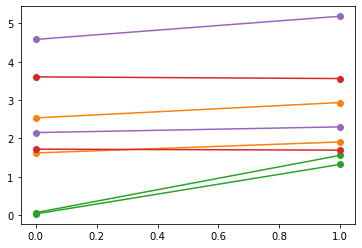

In [71]:
for CL in [344, 516]:
    for group in range(1, 5):
        plt.plot(df_sol.loc[('common', 'pca_tor'), group].isna(), df_sol.loc[(str(CL), 'Ca_rel'), group],
                 'o-', color=f'C{group}')

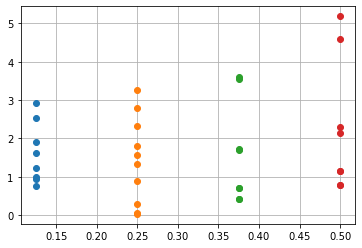

In [72]:
for i in range(1, 4+1):
    df_group = df.loc[:, idx[i, :, :]]

    plt.plot(df_group.loc['d_ord'] + i / 8, df_group.loc['Ca_rel'], 'o')
    
plt.grid()

# Analisys

In [73]:
plt.semilogy(-dump['common', 'fitness'].loc[idx[:, 0]],
             #color=palette_hc[-2],
            )
plt.grid(which='both')
plt.title('Loss')
plt.xlabel('epoch')
plt.tight_layout()

dirname = os.path.join("../images/maleckar/reports/", case,)
os.makedirs(dirname, exist_ok=True)     

plt.savefig(os.path.join(dirname, "loss.png"), dpi=600)

NameError: name 'dump' is not defined

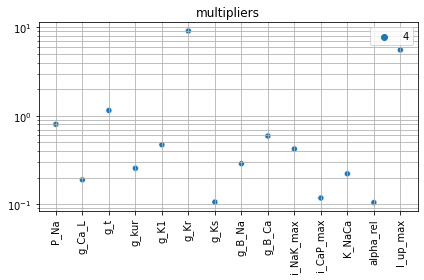

In [35]:
sns.scatterplot(data=df_sol.loc['common'])
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.yscale('log')
plt.grid(which='both')
plt.title('multipliers')

plt.tight_layout()

#plt.savefig("./images/koivumaki/reports/Fri_Dec_4_mults.png", dpi=300)

KeyError: 'Na_i'

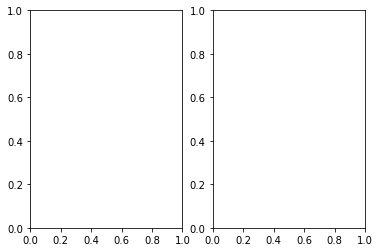

In [51]:
fig, axes = plt.subplots(ncols=2)

for i, item in enumerate(['Na_i', 'K_i']):
    plt.sca(axes[i])
    df = df_sol.loc[idx[:, item]].T.unstack().copy()
    df.index = df.index.astype('str')
    sns.scatterplot(data=df)
    plt.setp(plt.gca().get_xticklabels(), rotation=90)
    plt.grid()
    plt.title(item)
    plt.xlabel('CL')
    
plt.tight_layout()

#plt.savefig("./images/koivumaki/reports/Fri_Dec_4_params.png", dpi=300)

In [10]:
phenotype_model = {}
phenotype_model_last = {}
gc.collect()


for exp_cond_name in tqdm(config['experimental_conditions']):
    
    if exp_cond_name == 'common':
        continue
    
    if True:
        index_col = ['epoch', 'index']
        usecols = index_col + ['V',
                               #'Cai1', 'Cai2', 'Cai3', 'Cai4', 'Cass',
                               #'Nai', 'Ki',
                               'Na_i', 'K_i',
                               ] 

        filename = os.path.join(config_path, "phenotype", f"phenotype_{exp_cond_name}.csv")
        if os.path.isfile(filename):
            try:
                phenotype_model_last[exp_cond_name] = pd.read_csv(filename,
                                                                  #usecols=usecols
                                                                 )
                phen_len = len(phenotype_model_last[exp_cond_name])
            except pd.errors.EmptyDataError as e:
                print(f'{filename} is empty')
                continue

    
            if False:
                filename = os.path.join(config_path, "phenotype", f"phenotype_{exp_cond_name}.bin")    
                phenotype_model[exp_cond_name] = np.fromfile(filename, dtype=np.float32).reshape(-1, len(config['runtime']['states_initial']))

                n_epochs = len(phenotype_model[exp_cond_name]) // phen_len

                m_index_tuples = [(epoch, index) for epoch in range(n_epochs) for index in range(phen_len)]
                m_index = pd.MultiIndex.from_tuples(m_index_tuples)

                phenotype_model[exp_cond_name] = pd.DataFrame(phenotype_model[exp_cond_name],
                                                              index=m_index,
                                                              columns=phenotype_model_last[exp_cond_name].columns)

  0%|          | 0/5 [00:00<?, ?it/s]

In [53]:
#dump.columns.levels

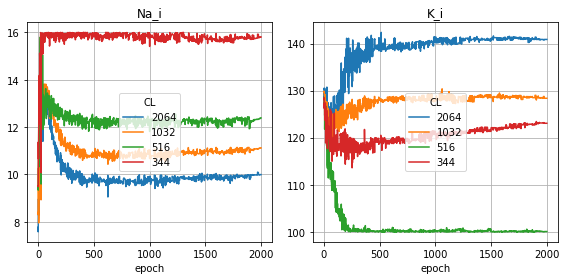

In [54]:
items = ['Na_i', 'K_i']


nrows = 1
ncols = len(items)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols),
                         #sharex='col', sharey='row',
                        )

for i, item in enumerate(items):
    plt.sca(axes[i])
    for column in dump:
        if item not in column:
            continue
        #max_epoch = dump.index[-1][0]
        #x_space = np.linspace(0, max_epoch, len(dump))
        plt.plot(dump.loc[idx[:, 0], column].values, label=column[0])
    plt.legend(title='CL', loc='center')
    plt.xlabel('epoch')
    plt.grid()
    plt.title(item)

dirname = os.path.join("../images/maleckar/reports/", case,)
os.makedirs(dirname, exist_ok=True)                

plt.tight_layout()
plt.savefig(os.path.join(dirname, "concentrations.png"), dpi=600)

CL = 2064, rmse_V = 1.346e+00
CL = 1032, rmse_V = 1.199e+00
CL = 516, rmse_V = 1.096e+00
CL = 344, rmse_V = 1.657e+00
CL = 2064, rmse_V = 1.466e+00
CL = 1032, rmse_V = 1.390e+00
CL = 516, rmse_V = 1.442e+00
CL = 344, rmse_V = 1.678e+00


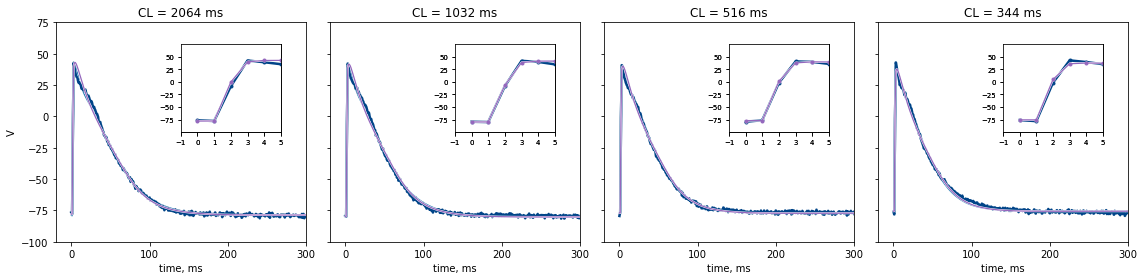

In [21]:
nrows = 1
ncols = 4 # len(exp_cond_dict)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols),
                         sharex='col', sharey='row')

for i_output in 0, 0+4:

    config = output_list[i_output]['config']
    phenotype_model_last = output_list[i_output]['phenotype_model_last']

    exp_cond_dict = [item for item in config['experimental_conditions'].items() if item[0] != 'common']

    item = 'V'

    for i_cond, (exp_cond_name, exp_cond) in enumerate(exp_cond_dict):

        ax = axes[i_cond]
        ax_inset = ax.inset_axes([0.5, 0.5, 0.4, 0.4])

        exp = exp_cond['phenotype']['V']
        model = phenotype_model_last[exp_cond_name]['V'].values[:len(exp)]

        exp, model = map(lambda x: np.roll(x, 1), [exp, model])

        rmse = calculate_RMSE(exp, model)

        ax.set_yticks(np.arange(-100, 75 + 1, 25))
        ax.set_ylim(-100, 75)

        print(f"CL = {exp_cond_name}, rmse_{item} = {rmse:.3e}")

        if i_cond == 0:
            ax.set_ylabel(item)

        for ml, ax_ in zip(['-', '.-'], [ax, ax_inset]):

            ax_.plot(exp, ml, color='w', lw=3)
            ax_.plot(exp, ml, color=palette_hc[3], lw=2.5, label='exp')

            ax_.plot(model, ml, color='w', lw=2)
            ax_.plot(model, ml,
                     color=f"C{i_output}", #palette_hc[2],
                     lw=1.25, label='model')

        ax.set_title(f'CL = {exp_cond_name} ms')
        ax.set_xlabel('time, ms')

        ax.set_xticks(np.arange(0, 750+1, 100))
        ax.set_xlim(-20, 300)


        ax_inset.set_xlim(-1, 5)
        ax_inset.set_ylim(ax.get_ylim())
        ax_inset.set_yticks(ax.get_yticks()[1:-1])
        ax_inset.set_xticks(np.arange(-1, 6, 1))
        ax_inset.tick_params(axis='both', labelsize='x-small')
        
    for ax_ in ax, ax_inset:
        ax.grid()

    fig.align_labels()
    plt.tight_layout()

    # dirname = os.path.join("../images/maleckar/reports/", case,)
    # os.makedirs(dirname, exist_ok=True)               

    # plt.savefig(os.path.join(dirname, "waveforms.png"), dpi=600, facecolor='white')

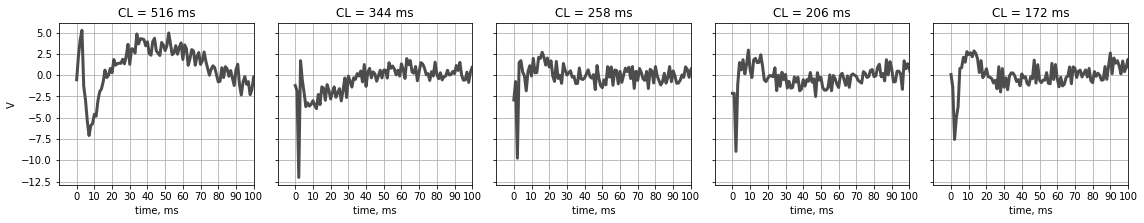

In [18]:
exp_cond_dict = [item for item in config['experimental_conditions'].items() if item[0] != 'common']


nrows = 1
ncols = len(exp_cond_dict)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols),
                         sharex='col', sharey='row')

item = 'V'

for i_cond, (exp_cond_name, exp_cond) in enumerate(exp_cond_dict):

    ax = axes[i_cond]

    exp = exp_cond['phenotype']['V']
    model = phenotype_model_last[exp_cond_name]['V'].values[:len(exp)]
    
    exp, model = map(lambda x: np.roll(x, 1), [exp, model])

#     ax.set_yticks(np.arange(-100, 75 + 1, 25))
#     ax.set_ylim(-100, 75)

    if i_cond == 0:
        ax.set_ylabel(item)

    ax.plot(exp - model, '-', color='0.3', lw=3)

    ax.grid()

    ax.set_title(f'CL = {exp_cond_name} ms')
    ax.set_xlabel('time, ms')
    
    ax.set_xlim(-10, 100)
    ax.set_xticks(np.arange(0, 100+1, 10))


              
dirname = os.path.join("../images/maleckar/reports/", case,)
os.makedirs(dirname, exist_ok=True)                

fig.align_labels()
plt.tight_layout()
#plt.savefig(os.path.join(dirname, "waveforms_diff.png"), dpi=600, facecolor='white')

In [19]:
import pyCardiac as pc

In [20]:
exp_cond_dict = [item for item in config['experimental_conditions'].items() if item[0] != 'common']

m_index = pd.MultiIndex.from_product([[x[0] for x in exp_cond_dict],
                                      ['exp', 'model']], names=['CL', None])

df = pd.DataFrame(index=m_index, columns=['RP', 'APA', 'dVdt_max', 'APD80'])

for i_cond, (exp_cond_name, exp_cond) in enumerate(exp_cond_dict):

    exp = exp_cond['phenotype']['V'].values
    model = phenotype_model_last[exp_cond_name]['V'].values[:len(exp)]
    
    df.loc[idx[exp_cond_name, :], 'RP'] = exp[-1], model[-1]
    df.loc[idx[exp_cond_name, :], 'APA'] = np.ptp(exp), np.ptp(model)
    df.loc[idx[exp_cond_name, :], 'dVdt_max'] = np.max(np.diff(exp)), np.max(np.diff(model))
    
    t = np.arange(len(exp))
    df.loc[idx[exp_cond_name, :], 'APD80'] = [pc.signal.analysis.calculate_APD(t, exp),
                                              pc.signal.analysis.calculate_APD(t, model)]

In [21]:
df

RP         APA   dVdt_max APD80
CL                                               
516 exp   -83.007812  129.394531  70.190430    97
    model -82.470832  124.368473  68.238244   103
344 exp   -76.293945  117.492676  72.021484    94
    model -75.076019  114.110646  82.212481    89
258 exp   -77.819824  115.356445  72.021484    88
    model -74.913128  110.763646  81.028040    83
206 exp   -73.852539  107.421875  75.378418    83
    model -71.721185  103.326965  82.202803    78
172 exp   -69.885254   97.961426  74.157715    76
    model -69.967803   97.598365  80.274809    74

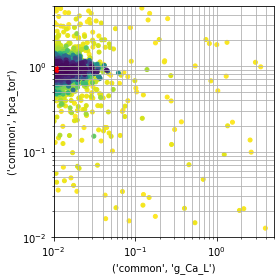

In [136]:
plt.figure(figsize=plt.figaspect(1))

name_x, name_y = ('common', 'g_Ca_L'), ('common', 'pca_tor')
#name_x, name_y = ('1032', 'K_i'), ('1032', 'Na_i')

epoch = 0

df = dump.loc[epoch][::-1]
#c = np.arange(len(df)) # np.log(-df['common', 'fitness'])

scat = plt.scatter(df[name_x], df[name_y], c=df.index, s=16)
line_best, = plt.plot(df[name_x].loc[0],
                      df[name_y].loc[0], 'Xr')

if genes[name_x[0]][name_x[1]].get('is_multiplier', False):
    plt.xscale('log')
if genes[name_y[0]][name_y[1]].get('is_multiplier', False):
    plt.yscale('log')

plt.xlabel(name_x)
plt.ylabel(name_y)

plt.xlim(genes[name_x[0]][name_x[1]]['bounds'])
plt.ylim(genes[name_y[0]][name_y[1]]['bounds'])

plt.grid(which='both')
plt.tight_layout()
#plt.gcf().align_labels()

dirname = os.path.join("../images/maleckar_tor/reports/", case, 'pairplots', "_".join(name_x + name_y))
os.makedirs(dirname, exist_ok=True)

for epoch in tqdm(range(0, dump.index[-1][0])):
    df = dump.loc[epoch][::-1]
    #c = np.arange(len(df)) # np.log(-df['common', 'fitness'])
    scat.set_offsets(df[[name_x, name_y]])
    scat.set_array(df.index)
    line_best.set_data(df[name_x].loc[0], df[name_y].loc[0])
    plt.savefig(os.path.join(os.path.join(dirname, f"pairplot_{epoch:04d}.png")), dpi=200)

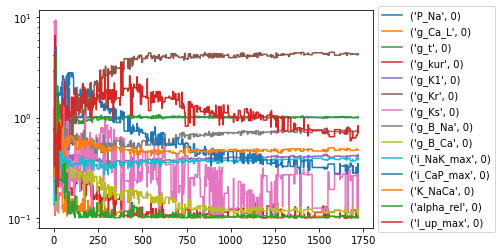

In [22]:
df = dump.loc[idx[:, 0], 'common'].unstack().iloc[:, 1:]

for key in df:
    plt.semilogy(df[key], label=key)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [401]:
l = []
for i in range(128):
    df = pd.read_csv(os.path.join(config_path, f"mpi/report_{i:04d}.csv")).iloc[1:]
    df['rank'] = i
    l.append(df)
    
df = pd.concat(l)
#df.set_index('rank', append=True, inplace=True)

<AxesSubplot:xlabel='rank', ylabel='gather_allgather'>

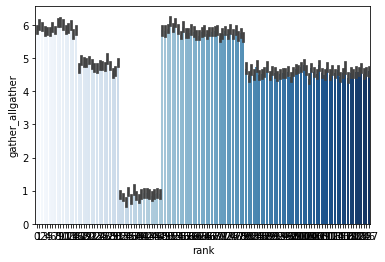

In [402]:
sns.barplot(y='gather_allgather', data=df, x='rank', palette="Blues")
#sns.barplot(y='calc', data=df, x='rank', palette="Reds")

# Prepare baselines

In [22]:
import numpy as np
import pandas as pd
import ctypes
import matplotlib.pyplot as plt

import time
import os

import sys
sys.path.append("../")

from src.helpers import update_array_from_kwargs, get_value_by_key

dirname = '../src/model_ctypes/_maleckar_ical_ghk_tor/'
filename_so = os.path.join(dirname, 'maleckar.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

# model.initialize_states_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]

# model.initialize_states_default.restype = ctypes.c_void_p


# model.initialize_constants_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]

# model.initialize_constants_default.restype = ctypes.c_void_p


model.computeRates.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
model.computeRates.restype = ctypes.c_void_p


model.computeVariables.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
model.computeVariables.restype = ctypes.c_void_p


model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')#,
    #np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'),
    #np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.run.restype = ctypes.c_int



model.run_chain.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'),
]

model.run_chain.restype = ctypes.c_int


legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')
legend_algebraic = legend_algebraic.iloc[:, :0]
legend_algebraic['value'] = 0.0

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']

In [105]:
# S = np.zeros(len(legend_states)) #  np.loadtxt("S.txt")
# C = np.zeros(len(legend_constants)) #  np.loadtxt("C.txt")

# model.initialize_states_default(S)
# model.initialize_constants_default(C)

In [106]:
# S = legend_states.copy()
# C = legend_constants.copy()

# A = legend_algebraic.copy()
# R = np.zeros(len(legend_states))

In [109]:
output['dump_last']

common                                                              \
       fitness      P_Na    g_Ca_L       g_t     g_kur      g_K1      g_Kr   
0    -8.554266  0.800753  0.339389  1.167351  0.518112  0.405900  8.556272   
1    -8.562090  0.801628  0.330075  1.143741  0.516353  0.425388  8.551451   
2    -8.562574  0.802608  0.319281  1.116543  0.508197  0.396686  8.899577   
3    -8.569455  0.804711  0.321498  1.084283  0.530553  0.402904  8.559764   
4    -8.577038  0.804003  0.303519  1.114362  0.472512  0.413203  9.048751   
...        ...       ...       ...       ...       ...       ...       ...   
8187      -inf  1.181449  0.377734  1.309770  0.541581  0.458250  6.421511   
8188      -inf  0.886302  0.404111  0.865207  0.255838  0.794878  4.360441   
8189      -inf  0.931253  0.790504  2.293964  0.652846  0.235549  7.167287   
8190      -inf  0.971894  0.361965  1.219831  0.561607  0.455288  7.734482   
8191      -inf  0.804284  0.299967  1.070240  0.665288  0.507396  8.364994   

                                    ...      2064       1032              \
          g_Ks    g_B_Na    g_B_Ca  ...    Ca_rel       Na_i         K_i   
0     0.317398  0.315340  0.461004  ...  0.783302  10.015795  123.851393   
1     0.112962  0.355010  0.473369  ...  0.809216  10.071009  124.495716   
2     0.285072  0.314416  0.457467  ...  0.761367   9.883678  124.482905   
3     0.328499  0.309924  0.456911  ...  0.758170   9.803107  124.282101   
4     0.110232  0.290557  0.487726  ...  0.833525  10.008984  124.402900   
...        ...       ...       ...  ...       ...        ...         ...   
8187  0.115122  0.421091  0.422144  ...  0.682271   9.973926  124.319969   
8188  0.173529  0.217409  0.484994  ...  0.805331  10.132906  124.542821   
8189  0.270454  3.805500  0.476442  ...  1.489992  10.243322  124.728994   
8190  0.115241  0.343000  0.503442  ...  0.781988   9.855244  124.547168   
8191  0.133554  0.389390  0.712812  ...  1.116317   9.769802  124.460992   

                      516                              344              \
        Ca_rel       Na_i         K_i    Ca_rel       Na_i         K_i   
0     1.164217  11.744849  100.084545  2.301952  15.860486  123.569630   
1     1.193121  11.778017  100.120226  2.294270  15.693292  123.407497   
2     1.116055  11.740612  100.311913  2.232196  15.538160  123.258177   
3     1.111321  11.524221  100.086855  2.178899  15.389816  123.892585   
4     1.201475  11.802703  100.081710  2.307138  15.473170  122.783997   
...        ...        ...         ...       ...        ...         ...   
8187  1.043548  11.662136  100.676174  2.091816  16.059065  123.114712   
8188  1.204404  12.578313  100.060776  2.568238  16.069276  122.152904   
8189  1.912421  11.777732   99.925927  3.058755  15.037855  123.798891   
8190  1.126001  11.792872   99.985910  2.226041  15.503123  122.400184   
8191  1.494953  11.855218   99.963229  2.706564  15.261826  122.497960   

                
        Ca_rel  
0     5.182798  
1     5.070440  
2     4.849849  
3     4.756002  
4     4.920158  
...        ...  
8187  4.815696  
8188  5.341353  
8189  5.760841  
8190  4.786494  
8191  5.337644  

[8192 rows x 28 columns]

In [23]:
output = output_list[-1]
genes = output['dump_last'].iloc[0, 1:]

state = pd.DataFrame({exp_cond_name: phenotype_model_last[exp_cond_name].iloc[-1]
                      for exp_cond_name in config['experimental_conditions'] if exp_cond_name != 'common'})

C, S = create_C_S(dict(genes=genes, state=state), config, '344')

stim_amplitude -60
stim_duration 0.001
Mg_i 1.0
Na_b 140
Ca_b 2.0
K_b 4
pca_tor 0
stim_period 0.344


In [196]:
C['g_K1'] *= 0.5
C['P_Na'] *= 0.6
C['g_Ca_L'] *= 0.5
#P_Ca_L_ToR_ORd*0.5

In [197]:
# C['stim_amplitude'] *= 2
# C['stim_amplitude']

In [7]:
S = legend_states.copy()
C = legend_constants.copy()

In [53]:
C['stim_amplitude'] = -180

In [98]:
C['stim_period'] = 1
C['stim_duration'] = 0.001
C['stim_amplitude'] = -60
#C['pca_tor'] = 0 # 5e-5 * 4
#C['g_Ca_L'] = 3 * 6.75

In [143]:
C['pca_tor'] = 5e-5 * 4


In [198]:
C['stim_period'] = 1

In [184]:
#C.to_csv("../../../projects/Rheeda/G3C1/andrey_constants.csv")

In [24]:
t_sampling = 0.001 # 0.001

stim_period = C['stim_period'] # C[config['stim_period_legend_name']]
#stim_period = get_value_by_key(C, legend_constants, 'stim_period')
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 100
tol = 1e-6

chain_length = 200
v_threshold = 1e-1
t_safe = 5e-2

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
#output_A = np.zeros((n_samples_per_stim * n_beats + 1, 107))
#output_t = np.zeros((n_samples_per_stim * n_beats + 1))

In [55]:
status = model.run_chain(S.values.copy(), C.values.copy(),
                         chain_length, v_threshold, t_safe,
                         n_beats, t_sampling, tol, output)

print(status)

2


In [25]:
status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

print(status)

2


In [26]:
#output = np.loadtxt(os.path.join(dirname, "output.txt"))

In [27]:
output = pd.DataFrame(output, columns=legend_states.index)

In [28]:
output[:10]

name,V,Na_c,Na_i,m,h1,h2,Ca_d,d_L,f_L1,f_L2,...,F2,d_ord,ff,fs,fcaf,fcas,jca,ffp,fcafp,nca
0,-75.591485,139.970328,15.860486,0.002721,9.056728e-01,0.796446,0.000295,1.467319e-14,0.998874,0.991619,...,0.013553,-3.811006e-22,1.000000,0.955019,1.000000,0.994577,0.993695,1.000001,1.000000,0.216033
1,5.313453,139.957136,15.862281,0.921608,5.253536e-01,0.745721,0.000305,1.030344e-02,0.986846,0.989815,...,0.013573,3.223330e-02,0.997346,0.955016,0.985933,0.994046,0.991742,0.998939,0.994342,0.217509
2,34.752505,139.937275,15.864982,0.999466,1.874238e-02,0.534333,0.000917,3.714768e-01,0.893010,0.974142,...,0.013613,7.877376e-01,0.891760,0.954200,0.870833,0.989547,0.978607,0.955212,0.946174,0.495595
3,30.736855,139.935350,15.865245,0.999146,6.690027e-04,0.382867,0.002357,6.173016e-01,0.808048,0.958707,...,0.013834,9.577767e-01,0.788110,0.953292,0.760634,0.983836,0.965645,0.909149,0.896329,0.791093
4,24.259445,139.933911,15.865441,0.998128,2.375695e-05,0.274336,0.004798,7.450181e-01,0.731195,0.943521,...,0.014857,9.621398e-01,0.704653,0.952449,0.670077,0.980083,0.952855,0.869342,0.852014,0.916301
5,17.910741,139.932626,15.865616,0.995952,1.030935e-06,0.196570,0.008162,7.701214e-01,0.661721,0.928587,...,0.017255,9.058315e-01,0.641708,0.951760,0.601139,0.978141,0.940235,0.837405,0.815806,0.965823
6,12.230715,139.931605,15.865756,0.991944,5.093148e-07,0.140849,0.012076,7.344691e-01,0.599000,0.913912,...,0.020816,8.169120e-01,0.596540,0.951288,0.552965,0.977213,0.927783,0.813309,0.788997,0.985414
7,7.245084,139.930913,15.865851,0.985309,1.238471e-06,0.100924,0.016084,6.684774e-01,0.542528,0.899518,...,0.024903,7.064633e-01,0.564940,0.951011,0.519795,0.976754,0.915500,0.795791,0.769709,0.993261
8,2.864837,139.930554,15.865900,0.975205,2.887403e-06,0.072320,0.019807,5.914033e-01,0.491952,0.885443,...,0.028947,5.846455e-01,0.542873,0.950859,0.493452,0.976494,0.903393,0.783200,0.753848,0.996463
9,-1.000050,139.930496,15.865909,0.960869,6.120419e-06,0.051831,0.023005,5.141138e-01,0.447136,0.871783,...,0.032587,4.620622e-01,0.527249,0.950770,0.467346,0.976272,0.891481,0.774083,0.737584,0.997803


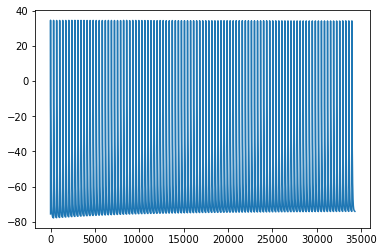

In [29]:
plt.plot(output.V)

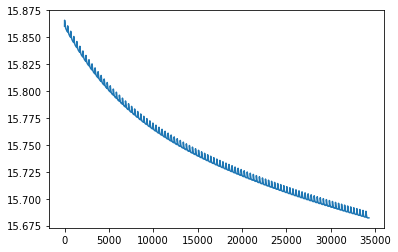

In [30]:
plt.plot(output.Na_i)

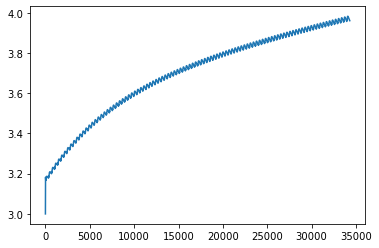

In [31]:
plt.plot(output.Ca_up)

In [48]:
A = legend_algebraic.values.flatten()
R = np.zeros(len(legend_states))

A_list = np.zeros((len(output), len(A)))
for i in range(len(output)):
    model.computeVariables(0, C.values, R, output.iloc[i].values, A)
    A_list[i] = A.copy()

In [49]:
A = pd.DataFrame(A_list, columns=legend_algebraic.index)

In [50]:
A

name,Q_tot,past,m_factor,h_infinity,d_L_infinity,f_L_infinity,r_infinity,s_infinity,a_ur_infinity,i_ur_infinity,...,J_O_TC,J_O_TMgC,J_O,i_rel_f2,i_rel_factor,i_rel,i_up,i_tr,J_O_Calse,ical_tor
0,-3.642397,0.0,-1.641595,8.513074e-01,1.402532e-14,0.998343,0.001213,0.943367,0.000421,0.998550,...,-0.002968,-0.001221,-0.000610,0.015868,0.000252,93.828307,71.749642,91.413006,-0.000803,1.127515e-17
1,0.594137,0.0,1.300442,6.527788e-07,6.039391e-01,0.003939,0.728958,0.010405,0.888884,0.125838,...,0.127895,0.008582,0.022235,0.015870,0.000252,93.839217,77.825868,91.442424,-0.000804,-1.176560e+01
2,1.647253,0.0,2.031773,1.227074e-08,1.000000e+00,0.000204,0.948049,0.001681,0.989318,0.017217,...,0.218184,0.018672,0.036658,0.016200,0.000262,97.789108,84.814046,91.648798,-0.001745,-4.777314e+01
3,1.314085,0.0,1.800407,4.314009e-08,9.277465e-01,0.000520,0.908739,0.002997,0.977105,0.032985,...,0.330199,0.032089,0.055292,0.017646,0.000311,116.015332,94.218977,92.861293,-0.006908,-7.262526e+01
4,0.949557,0.0,1.547262,1.707210e-07,7.707336e-01,0.001451,0.836930,0.005635,0.948140,0.066044,...,0.516954,0.053541,0.086749,0.019714,0.000389,144.762324,109.355963,96.216141,-0.015286,-9.181765e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34296,-3.645548,0.0,-1.643783,8.528064e-01,1.288338e-14,0.998358,0.001206,0.943659,0.000418,0.998559,...,-0.002958,-0.001217,-0.000608,0.015865,0.000252,93.822186,71.900218,91.440383,-0.000798,2.697860e-19
34297,-3.645692,0.0,-1.643883,8.528746e-01,1.283341e-14,0.998358,0.001206,0.943672,0.000418,0.998560,...,-0.002956,-0.001216,-0.000608,0.015865,0.000252,93.822292,71.899737,91.440393,-0.000798,4.137659e-19
34298,-3.645834,0.0,-1.643982,8.529421e-01,1.278418e-14,0.998359,0.001205,0.943686,0.000417,0.998560,...,-0.002955,-0.001215,-0.000607,0.015865,0.000252,93.822396,71.899286,91.440405,-0.000798,5.125819e-19
34299,-3.645975,0.0,-1.644080,8.530087e-01,1.273567e-14,0.998360,0.001205,0.943699,0.000417,0.998560,...,-0.002953,-0.001214,-0.000607,0.015865,0.000252,93.822500,71.898863,91.440420,-0.000798,5.310537e-19


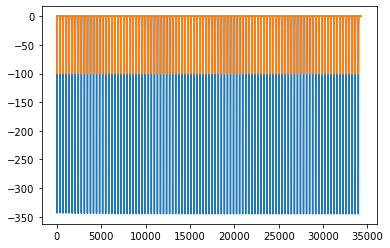

In [51]:
plt.plot(A.i_Ca_L)
plt.plot(A.ical_tor)

#plt.xlim(990, 1200)

In [207]:
#output.to_csv("../../../projects/Rheeda/G3C1/andrey_normal.csv", index=False)

In [208]:
tail = output[-1000 * 10 - 1:].reset_index()

In [209]:
tail

name,index,V,Na_c,Na_i,m,h1,h2,Ca_d,d_L,f_L1,...,O_C,O_TC,O_TMgC,O_TMgMg,O,Ca_rel,Ca_up,O_Calse,F1,F2
0,990000,-55.024745,140.021349,5.633908,0.032331,0.164876,0.158473,0.000055,0.000358,0.979689,...,0.009905,0.004740,0.154520,0.634265,1.375071,0.246570,0.247918,0.228319,0.522022,0.000090
1,990001,11.169576,140.017669,5.634408,0.986784,0.037737,0.134569,0.000143,0.097267,0.944823,...,0.009963,0.004763,0.154520,0.634270,1.375075,0.246578,0.248145,0.228323,0.522408,0.000091
2,990002,13.269086,140.016601,5.634553,0.992760,0.001347,0.096423,0.001218,0.417354,0.855242,...,0.010079,0.004812,0.154543,0.634258,1.375088,0.246587,0.248714,0.228328,0.522627,0.000256
3,990003,11.979645,140.016928,5.634508,0.991589,0.000049,0.069091,0.002852,0.620633,0.774190,...,0.010205,0.004867,0.154579,0.634236,1.375104,0.246059,0.249458,0.228294,0.520073,0.003156
4,990004,9.642786,140.017446,5.634438,0.988886,0.000003,0.049506,0.004627,0.744745,0.700956,...,0.011123,0.005244,0.154821,0.634135,1.375214,0.236759,0.253438,0.227148,0.510471,0.012895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,999996,-55.017970,140.020334,5.631853,0.032357,0.164676,0.158123,0.000055,0.000358,0.979657,...,0.009901,0.004738,0.154499,0.634280,1.375067,0.246396,0.247804,0.228193,0.520465,0.000090
9997,999997,-55.018539,140.020317,5.631856,0.032354,0.164697,0.158181,0.000055,0.000358,0.979662,...,0.009901,0.004737,0.154484,0.634291,1.375065,0.246401,0.247795,0.228197,0.520852,0.000090
9998,999998,-55.019102,140.020300,5.631858,0.032352,0.164717,0.158239,0.000055,0.000358,0.979666,...,0.009900,0.004737,0.154470,0.634302,1.375062,0.246407,0.247785,0.228202,0.521240,0.000090
9999,999999,-55.019658,140.020283,5.631860,0.032350,0.164738,0.158297,0.000055,0.000358,0.979671,...,0.009900,0.004737,0.154456,0.634313,1.375060,0.246412,0.247776,0.228206,0.521627,0.000090


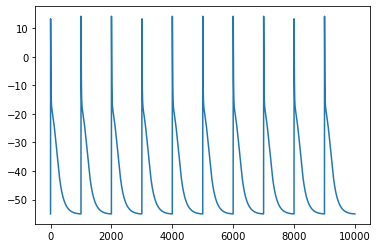

In [210]:
plt.plot(tail.V)

In [211]:
tail.to_csv("../../../projects/Rheeda/G3C1/andrey_fibrosis.csv", index=False)

In [212]:
tail

name,index,V,Na_c,Na_i,m,h1,h2,Ca_d,d_L,f_L1,...,O_C,O_TC,O_TMgC,O_TMgMg,O,Ca_rel,Ca_up,O_Calse,F1,F2
0,990000,-55.024745,140.021349,5.633908,0.032331,0.164876,0.158473,0.000055,0.000358,0.979689,...,0.009905,0.004740,0.154520,0.634265,1.375071,0.246570,0.247918,0.228319,0.522022,0.000090
1,990001,11.169576,140.017669,5.634408,0.986784,0.037737,0.134569,0.000143,0.097267,0.944823,...,0.009963,0.004763,0.154520,0.634270,1.375075,0.246578,0.248145,0.228323,0.522408,0.000091
2,990002,13.269086,140.016601,5.634553,0.992760,0.001347,0.096423,0.001218,0.417354,0.855242,...,0.010079,0.004812,0.154543,0.634258,1.375088,0.246587,0.248714,0.228328,0.522627,0.000256
3,990003,11.979645,140.016928,5.634508,0.991589,0.000049,0.069091,0.002852,0.620633,0.774190,...,0.010205,0.004867,0.154579,0.634236,1.375104,0.246059,0.249458,0.228294,0.520073,0.003156
4,990004,9.642786,140.017446,5.634438,0.988886,0.000003,0.049506,0.004627,0.744745,0.700956,...,0.011123,0.005244,0.154821,0.634135,1.375214,0.236759,0.253438,0.227148,0.510471,0.012895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,999996,-55.017970,140.020334,5.631853,0.032357,0.164676,0.158123,0.000055,0.000358,0.979657,...,0.009901,0.004738,0.154499,0.634280,1.375067,0.246396,0.247804,0.228193,0.520465,0.000090
9997,999997,-55.018539,140.020317,5.631856,0.032354,0.164697,0.158181,0.000055,0.000358,0.979662,...,0.009901,0.004737,0.154484,0.634291,1.375065,0.246401,0.247795,0.228197,0.520852,0.000090
9998,999998,-55.019102,140.020300,5.631858,0.032352,0.164717,0.158239,0.000055,0.000358,0.979666,...,0.009900,0.004737,0.154470,0.634302,1.375062,0.246407,0.247785,0.228202,0.521240,0.000090
9999,999999,-55.019658,140.020283,5.631860,0.032350,0.164738,0.158297,0.000055,0.000358,0.979671,...,0.009900,0.004737,0.154456,0.634313,1.375060,0.246412,0.247776,0.228206,0.521627,0.000090


In [41]:
err_abs = output.iloc[-1] - output.iloc[0]
err_rel = err_abs / output.iloc[0] * 100

In [42]:
items = ['Na_i', 'K_i', 'V', 'Ca_i']
df_err= pd.DataFrame([err_rel[items], err_abs[items]],
                     index=['err_rel', 'err_abs'])
df_err

name,Na_i,K_i,V,Ca_i
err_rel,0.025863,-0.001162,0.019177,-5.679645e-02
err_abs,0.001577,-0.001520,-0.015671,-6.649527e-09


# 3D

spherical stimulus of radius 0.75mm

stimulus[0].strength     = 3e2 units: uA/cm^3(3D current)

stimulus[0].duration     = 5 [ms]

$(100 um)^3 \cdot 300 uA / cm^3 = (10^2 \cdot 10^{-6} m)^3 \cdot 3 \cdot 10^{-4} \cdot 10^6 A/m^{-3} = 10^{-12} m^3 \cdot 3 \cdot 10^2 A / m^3 = 3 \cdot 10^{-10} A = 10 nA$

Cm = 0.05 nF

In [124]:
def calculate_diffusion(V, g_gap_junc_tensor):
        
    I = np.zeros_like(V)
        
    for axis in range(V.ndim):

        indices_next, indices_prev = [slice(None)] * 3, [slice(None)] * 3
        indices_next[axis] = slice(1, None)        
        indices_prev[axis] = slice(0, -1)
        indices_next = tuple(indices_next)
        indices_prev = tuple(indices_prev)

        I[indices_next] = I[indices_next] - g_gap_junc_tensor[axis] * (V[indices_prev] - V[indices_next])
        I[indices_prev] = I[indices_prev] - g_gap_junc_tensor[axis] * (V[indices_next] - V[indices_prev])
            
    return I


def is_pacing_condition(t, ix, iy, iz, SIZE, stim_size):
    
    X_SIZE, Y_SIZE, Z_SIZE = SIZE

    pacing_condition =  (X_SIZE / 2 - stim_size / 2 <= ix <= X_SIZE / 2 + stim_size / 2)
    pacing_condition &= (Y_SIZE / 2 - stim_size / 2 <= iy <= Y_SIZE / 2 + stim_size / 2)
    pacing_condition &= (iz == 0)

    pacing_condition &= t < 5e-3
    
    return pacing_condition


def is_pacing_condition_sphere(t, ix, iy, iz, SIZE, R):
    
    X_SIZE, Y_SIZE, Z_SIZE = SIZE
    
    x_center, y_center, z_center = X_SIZE / 2, Y_SIZE / 2, 0

    pacing_condition =  (ix - x_center)**2 + (iy - y_center)**2 + (iz - z_center)**2 < R**2
    pacing_condition &= t < 5e-3
    
    return pacing_condition

In [157]:
dt = 2e-5

t_end = 2e-2
t_sampling = 1e-4

sigma_l = 0.126  # S/m
h = 100  # um

g_gap_junc = sigma_l * h # 5.0
g_gap_junc_tensor = [g_gap_junc,
                     g_gap_junc / 5,
                     g_gap_junc / 5]

N = int(t_end / dt)
step_print = int(t_sampling / dt)


X_SIZE, Y_SIZE, Z_SIZE = 61, 41, 21
SIZE = X_SIZE, Y_SIZE, Z_SIZE

A = np.zeros(70)
R = np.zeros_like(S)

S_tissue = np.tile(S.values, (*SIZE, 1))
C_tissue = np.tile(C.values, (*SIZE, 1))
C_tissue[:, :, :, 7] = 0
R_tissue = np.zeros_like(S_tissue)
A_tissue = np.tile(A, (*SIZE, 1))

result = np.zeros((*SIZE, int(t_end / t_sampling)))
i_print = 0
t = 0

stim_size = 10

In [158]:
IS_PARALLEL = False

for it in tqdm(range(N)):
    
    if it % step_print == 0:
        result[:, :, :, i_print] = S_tissue[:, :, :, 0]
        i_print += 1
        
    if IS_PARALLEL:

        C_tissue[X_SIZE / 2 - stim_size / 2: X_SIZE / 2 + stim_size / 2,
                 Y_SIZE / 2 - stim_size / 2: Y_SIZE / 2 + stim_size / 2,
                 0, 7] = -300 if t < 5e-3 else 0 

        args = zip([t] * (X_SIZE * Y_SIZE * Z_SIZE),
                   C_tissue.reshape(-1, C_tissue.shape[-1]),
                   R_tissue.reshape(-1, R_tissue.shape[-1]),
                   S_tissue.reshape(-1, S_tissue.shape[-1]),
                   A_tissue.reshape(-1, A_tissue.shape[-1]))

        with Pool(2) as p:
            R_list = p.map(f, args)

        R_tissue = np.array(R_list).reshape(R_tissue.shape)
        
    else:

        for ix in range(X_SIZE):
            for iy in range(Y_SIZE):
                for iz in range(Z_SIZE):

                    stim_amplitude = -200
                    #C['stim_amplitude'] = stim_amplitude if is_pacing_condition(t, ix, iy, iz, SIZE, stim_size) else 0
                    C['stim_amplitude'] = stim_amplitude if is_pacing_condition_sphere(t, ix, iy, iz, SIZE, R=7.5) else 0


                    model.computeRates(t,
                                       C.values,
                                       R_tissue[ix, iy, iz],
                                       S_tissue[ix, iy, iz],
                                       A.copy())

    V = S_tissue[:, :, :, 0]
    assert not np.any(np.isnan(V))
    I_gap_junc = calculate_diffusion(V, g_gap_junc_tensor)
    
    R_tissue[:, :, :, 0] = R_tissue[:, :, :, 0] - I_gap_junc * 1000
    
    S_tissue = S_tissue + dt * R_tissue            
    t += dt

  0%|          | 0/999 [00:00<?, ?it/s]

ArgumentError: argument 5: <class 'KeyboardInterrupt'>: 

In [159]:
ixc, iyc, izc = map(lambda x: int(x // 2), SIZE)
ic = ixc, iyc, izc

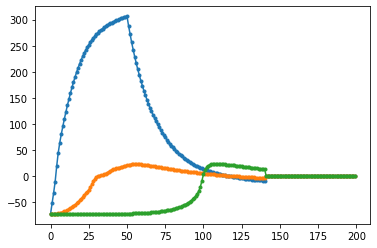

In [160]:
plt.plot(result[ixc, iyc, 0], '.-')
plt.plot(result[ic], '.-')
plt.plot(result[ixc, iyc, -1], '.-')

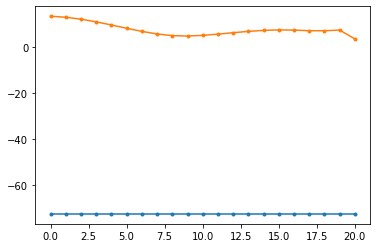

In [161]:
plt.plot(result[ixc, iyc, :, 0], '.-')
plt.plot(result[ixc, iyc, :, 100], '.-')

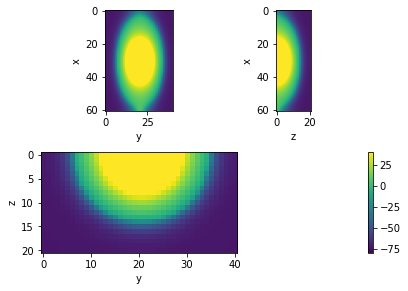

In [166]:
fig, axes = plt.subplots(2, 2,
                        #sharex='col', sharey='row',
                        )

t = 60

axes[0, 0].imshow(result[:, :, 0, t],
           vmin=-80, vmax=40,
           #aspect=10,
          )
axes[0, 0].set_xlabel('y')
axes[0, 0].set_ylabel('x')

axes[0, 1].imshow(result[:, iyc, :, t],
           vmin=-80, vmax=40,
           #aspect=10,
          )

axes[0, 1].set_xlabel('z')
axes[0, 1].set_ylabel('x')

im = axes[1, 0].imshow(result[ixc, :, :, t].T,
           vmin=-80, vmax=40,
           #aspect=10,
          )

axes[1, 0].set_xlabel('y')
axes[1, 0].set_ylabel('z')

axes[1, 1].set_visible(False)

plt.colorbar(im)

plt.tight_layout()

# Save

In [78]:
output = output[-CL - 1:]
print(output.shape)

(259, 43)


In [148]:
S = output[-1]
#np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/states/state_{CL}.txt", S)

In [150]:
V = output[:, 23]
Ca_i_mean = output.T[4: 9].mean(axis=0)
phenotype = np.vstack([V, Ca_i_mean]).T
#np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt", phenotype)

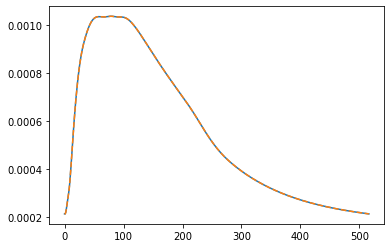

In [156]:
Ca_i_mean = output.T[4: 9].mean(axis=0)
Ca_i_sum  = output.T[4: 9].sum(axis=0)
plt.plot(Ca_i_mean)
plt.plot(Ca_i_sum / 5, '--')

In [165]:
for CL in [2000, 1500, 1000, 500, 333, 250, 200, 166]:
    phenotype = np.loadtxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt")
    np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt", phenotype.T)

In [163]:
a = np.loadtxt("./cases/maleckar/v0/baselines/V_Ca_i_1000.txt")

# Voigt

71.71630859375


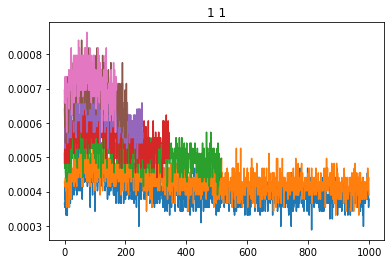

74.462890625


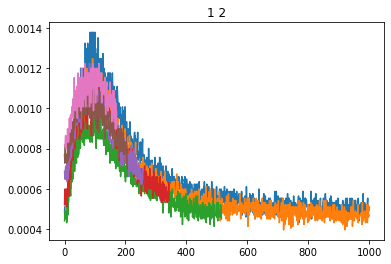

67.138671875


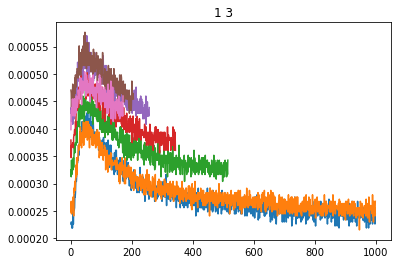

57.67822265625


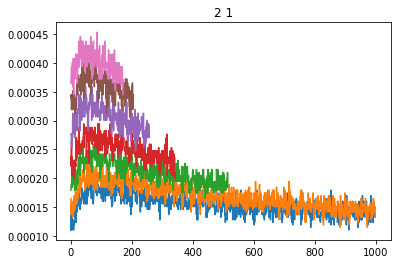

65.00244140625


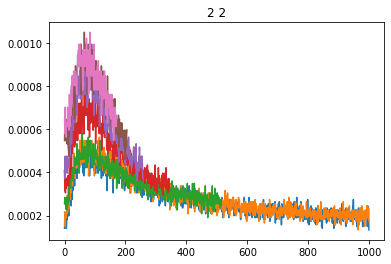

95.21484375


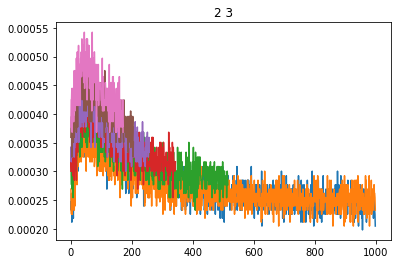

76.59912109375


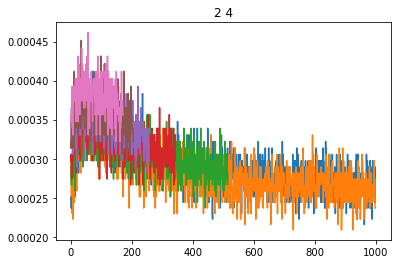

81.48193359375


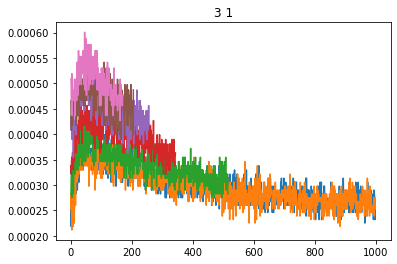

88.5009765625


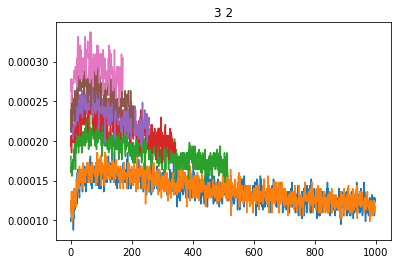

59.2041015625


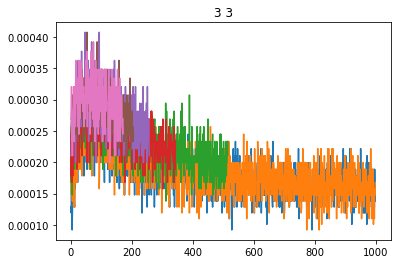

133.36181640625


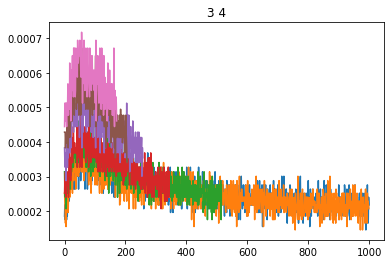

87.58544921875


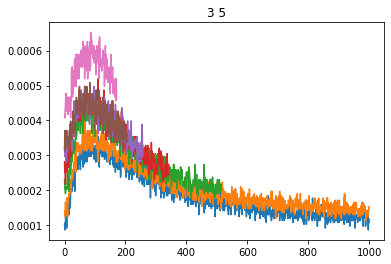

86.669921875


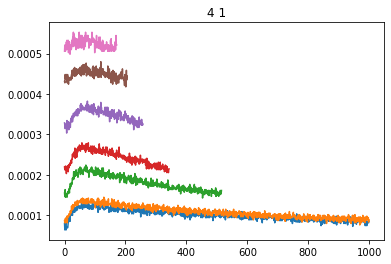

107.421875


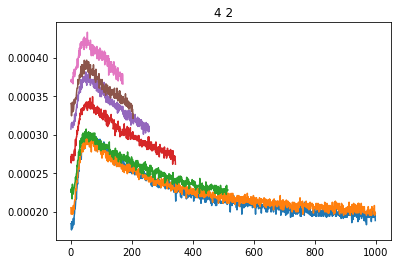

66.5283203125


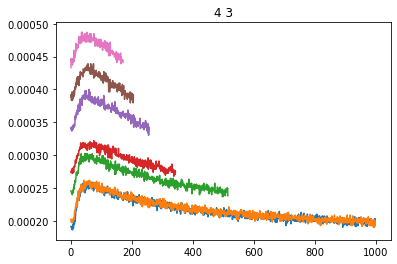

92.46826171875


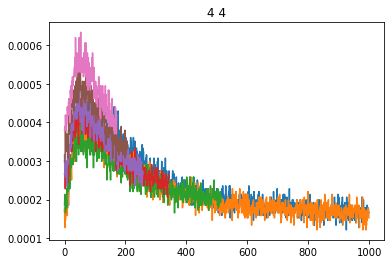

84.53369140625


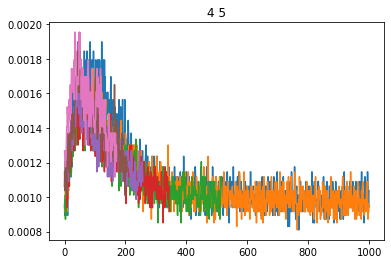

86.97509765625


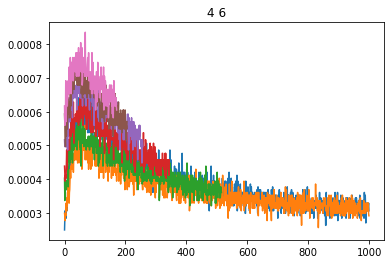

79.9560546875


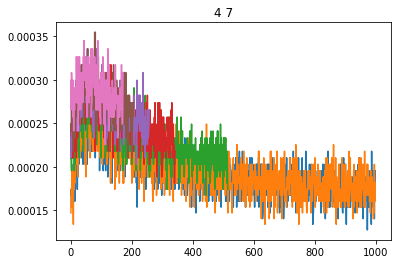

72.93701171875


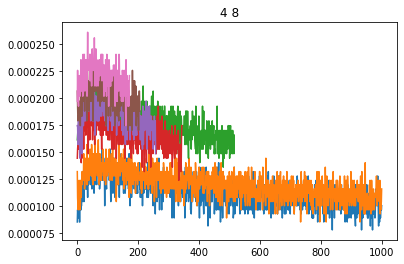

In [370]:
group_indices = range(1, 4 + 1)
cell_indices = [3, 4, 5, 8]

CL_list = [2064, 1032, 516, 344, 258, 206, 172]

df_CaT = pd.read_csv("/home/andrey/Dropbox/Voigt/voigt_CaT_params.csv")
df_CaT.set_index(['Group', 'Cell'], inplace=True)

dV_list = []

for ig in group_indices:
    for ic in range(1, cell_indices[ig-1] + 1):
        for CL in CL_list:
            sweep = np.loadtxt(f"../../Data/Voigt/Action_potentials_AG_Voigt/chosen_sweeps/{ig}_{ic}_{CL}.txt")
            phenotype = sweep[::10, [0, 2]]
                        
            FBL, Fmax = df_CaT.loc[(ig, ic), :]
            K = 864 / 1000. / 1000. # mM
            F = phenotype[:, 1]
            cat = K * (F - FBL) / (Fmax - F)
            
            phenotype[:, 1] = cat
            
            v = phenotype[:, 0]
            v = np.clip(v, a_min=None, a_max=np.max(v[2:]))
            phenotype[:, 0] = v

            phenotype = phenotype[:1000]
            
            #break
            #phenotype = pd.DataFrame(['V', 'Ca_i']
            dirsave = f"/home/andrey/WORK/Reentry/pypoptim/data/voigt/G{ig}/C{ic}/phenotypes"
            if not os.path.isdir(dirsave):
                os.makedirs(dirsave)
            #np.savetxt(os.path.join(dirsave, f"V_CaT_{CL}.txt"), phenotype)
            pd.DataFrame(phenotype, columns=['V', 'Cai']).to_csv(os.path.join(dirsave, f"phenotype_{CL}.csv"), index=False)
            # v = v.reshape(-1, 10).mean(axis=1)
            plt.plot(phenotype[:, 1])
            
            if CL == 1032:
                dV_max = np.max(np.diff(phenotype[:, 0]))
                dV_list.append(dV_max)
                print(dV_max)
            
        plt.title(f'{ig} {ic}')
        plt.show()

            #plt.xlim([-10, 100])

In [6]:
phenotype.shape

(1000, 2)

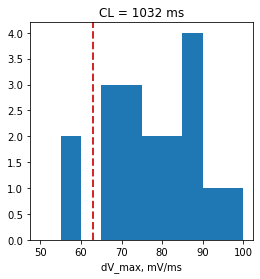

In [134]:
plt.figure(figsize=plt.figaspect(1))

plt.hist(dV_list, bins=list(range(50, 101, 5)))
plt.axvline(63, color='C3', ls='--', lw=2)

plt.xlabel('dV_max, mV/ms')
plt.title('CL = 1032 ms')
plt.savefig("./images/koivumaki/dV_max_voigt.png", dpi=300)

In [169]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%y%m%d_%H%M%S")
print("date and time =", dt_string)	


now = 2020-12-02 22:57:51.774292
date and time = 201202_225751


In [178]:
os.makedirs("test", exist_ok=True)

In [582]:
#

In [597]:
df = pd.read_csv("../src/model_ctypes/_maleckar_tor/legend_constants.csv")

In [601]:
for i in range(len(df)):
    line = f"CONSTANTS[{i}]\t= {df['value'].iloc[i]:.6e};\t//  {df['name'].iloc[i]}\n"
    print(line, end='')

CONSTANTS[0]	= 8.314000e+03;	//  R
CONSTANTS[1]	= 3.061500e+02;	//  T
CONSTANTS[2]	= 9.648700e+04;	//  F
CONSTANTS[3]	= 5.000000e+01;	//  Cm
CONSTANTS[4]	= 0.000000e+00;	//  stim_offset
CONSTANTS[5]	= 1.000000e+00;	//  stim_period
CONSTANTS[6]	= 6.000000e-03;	//  stim_duration
CONSTANTS[7]	= -1.500000e+01;	//  stim_amplitude
CONSTANTS[8]	= 1.800000e-03;	//  P_Na
CONSTANTS[9]	= 6.750000e+00;	//  g_Ca_L
CONSTANTS[10]	= 6.000000e+01;	//  E_Ca_app
CONSTANTS[11]	= 2.500000e-02;	//  k_Ca
CONSTANTS[12]	= 8.250000e+00;	//  g_t
CONSTANTS[13]	= 2.250000e+00;	//  g_kur
CONSTANTS[14]	= 3.100000e+00;	//  g_K1
CONSTANTS[15]	= 1.000000e+00;	//  g_Ks
CONSTANTS[16]	= 5.000000e-01;	//  g_Kr
CONSTANTS[17]	= 6.059900e-02;	//  g_B_Na
CONSTANTS[18]	= 7.868100e-02;	//  g_B_Ca
CONSTANTS[19]	= 1.000000e+00;	//  K_NaK_K
CONSTANTS[20]	= 6.855000e+01;	//  i_NaK_max
CONSTANTS[21]	= 3.648290e+01;	//  pow_K_NaK_Na_15
CONSTANTS[22]	= 4.000000e+00;	//  i_CaP_max
CONSTANTS[23]	= 2.000000e-04;	//  k_CaP
CONSTANTS[24]	= 

In [589]:
df

,name,value,component,units
0,V,-74.031982,membrane,millivolt
1,Na_c,130.022096,cleft_space_ion_concentrations,millimolar
2,Na_i,8.516766,intracellular_ion_concentrations,millimolar
3,m,0.003289,sodium_current_m_gate,dimensionless
4,h1,0.877202,sodium_current_h1_gate,dimensionless
5,h2,0.873881,sodium_current_h2_gate,dimensionless
6,Ca_d,0.000071,intracellular_ion_concentrations,millimolar
7,d_L,0.000014,L_type_Ca_channel_d_L_gate,dimensionless
8,f_L1,0.998597,L_type_Ca_channel_f_L1_gate,dimensionless
9,f_L2,0.998586,L_type_Ca_channel_f_L2_gate,dimensionless


# Rheeda (8 Jan)

In [213]:
columns = ['t', 'v', 'ist']

df_rheeda_norm = pd.DataFrame(np.loadtxt("../../../projects/Rheeda/G3C1/output_grp2.txt"), columns=columns)
df_rheeda_fibr = pd.DataFrame(np.loadtxt("../../../projects/Rheeda/G3C1/output_grp2fib.txt"), columns=columns)

In [214]:
df_rheeda_norm.to_csv("../../../projects/Rheeda/G3C1/output_grp2.csv", index=False)
df_rheeda_fibr.to_csv("../../../projects/Rheeda/G3C1/output_grp2fib.csv", index=False)

In [215]:
df_andrey_norm = pd.read_csv("../../../projects/Rheeda/G3C1/andrey_normal.csv")
df_andrey_fibr = pd.read_csv("../../../projects/Rheeda/G3C1/andrey_fibrosis.csv")

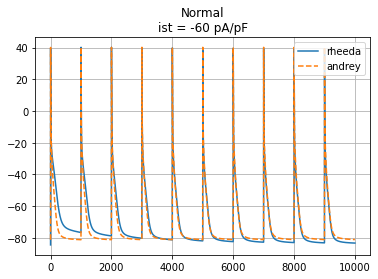

In [223]:
plt.plot(df_rheeda_norm.t, df_rheeda_norm.v, label='rheeda')
plt.plot(df_andrey_norm.V, '--', label='andrey')

plt.grid()
plt.legend()

plt.title("Normal\nist = -60 pA/pF")

plt.savefig("../../../projects/Rheeda/G3C1/images/normal.png", dpi=300)

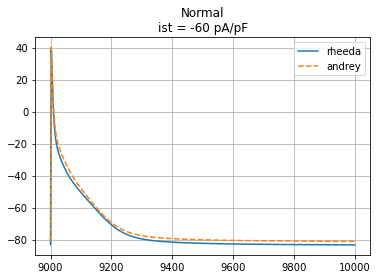

In [224]:
plt.plot(df_rheeda_norm.t[-1001:], df_rheeda_norm.v[-1001:], label='rheeda')
plt.plot(df_andrey_norm.V[-1001:], '--', label='andrey')

plt.grid()
plt.legend()

plt.title("Normal\nist = -60 pA/pF")

plt.savefig("../../../projects/Rheeda/G3C1/images/normal_one_beat.png", dpi=300)

In [248]:
pc.signal.analysis.calculate_APD(df_rheeda_norm.t[-1001:], df_rheeda_norm.v[-1001:])

139.0

In [251]:
pc.signal.analysis.calculate_APD(df_rheeda_norm.t[-1001:], df_andrey_norm.V[-1001:])

137.0

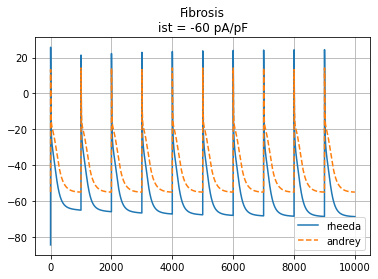

In [225]:
plt.plot(df_rheeda_fibr.t, df_rheeda_fibr.v, label='rheeda')
plt.plot(df_andrey_fibr.V, '--', label='andrey')

plt.grid()
plt.legend()

plt.title("Fibrosis\nist = -60 pA/pF")

plt.savefig("../../../projects/Rheeda/G3C1/images/fibrosis.png", dpi=300)

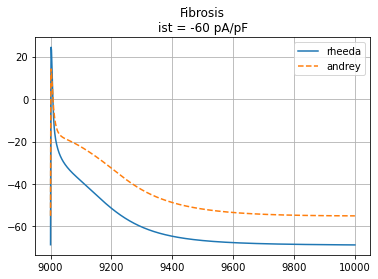

In [226]:
plt.plot(df_rheeda_fibr.t[-1001:], df_rheeda_fibr.v[-1001:], label='rheeda')
plt.plot(df_andrey_fibr.V[-1001:], '--', label='andrey')

plt.grid()
plt.legend()

plt.title("Fibrosis\nist = -60 pA/pF")

plt.savefig("../../../projects/Rheeda/G3C1/images/fibrosis_one_beat.png", dpi=300)

In [231]:
%matplotlib inline

(-10.0, 100.0)

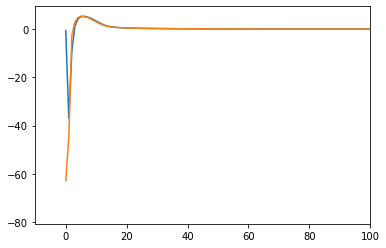

In [238]:
plt.plot(df_rheeda_fibr.ist)
plt.plot(-np.diff(df_rheeda_fibr.v))

plt.xlim(-10, 100)

In [189]:
df_rheeda_norm[:1]

,t,v,ist
0,0.0,-84.471006,-0.394154


In [190]:
df_andrey_norm

,V,Na_c,Na_i,m,h1,h2,Ca_d,d_L,f_L1,f_L2,...,O_C,O_TC,O_TMgC,O_TMgMg,O,Ca_rel,Ca_up,O_Calse,F1,F2
0,-81.229237,139.959082,8.273438,0.001371,0.965157,0.963456,0.000027,0.000004,0.999490,0.999484,...,0.010674,0.005109,0.164216,0.626991,1.376686,0.267990,0.267668,0.243337,0.550704,0.000126
1,-11.296079,139.953183,8.274240,0.694911,0.758430,0.930072,0.000033,0.005504,0.995640,0.998945,...,0.010766,0.005147,0.164227,0.626992,1.376695,0.267990,0.268026,0.243336,0.551065,0.000126
2,40.123775,139.921676,8.278526,0.999719,0.027176,0.666546,0.001429,0.372836,0.901868,0.983295,...,0.011210,0.005330,0.164339,0.626937,1.376748,0.268003,0.269983,0.243337,0.551198,0.000354
3,38.355507,139.921817,8.278507,0.999661,0.000969,0.477601,0.003759,0.619014,0.816051,0.967713,...,0.011748,0.005562,0.164518,0.626824,1.376819,0.266207,0.272893,0.243215,0.546261,0.005582
4,32.566485,139.922800,8.278374,0.999317,0.000035,0.342216,0.006372,0.768093,0.738407,0.952380,...,0.014657,0.006763,0.165326,0.626458,1.377175,0.239351,0.285183,0.239744,0.529649,0.022121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,-81.098091,139.950872,8.278398,0.001393,0.964304,0.962204,0.000027,0.000004,0.999480,0.999476,...,0.010735,0.005139,0.165219,0.626239,1.376852,0.269205,0.269176,0.244170,0.537400,0.000125
9997,-81.098943,139.950877,8.278398,0.001393,0.964310,0.962223,0.000027,0.000004,0.999480,0.999476,...,0.010734,0.005139,0.165205,0.626249,1.376850,0.269204,0.269164,0.244169,0.537772,0.000125
9998,-81.099793,139.950882,8.278398,0.001393,0.964316,0.962241,0.000027,0.000004,0.999481,0.999476,...,0.010734,0.005138,0.165192,0.626259,1.376848,0.269204,0.269153,0.244168,0.538145,0.000125
9999,-81.100642,139.950888,8.278398,0.001393,0.964322,0.962259,0.000027,0.000004,0.999481,0.999476,...,0.010733,0.005138,0.165179,0.626269,1.376845,0.269203,0.269141,0.244168,0.538516,0.000125
